# Описание проекта

**Анализ и разработка плана действий по удержанию клиентов фитнес-центра**

Для это требуется:<br>
    • спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;<br>
    • сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;<br>
    • проанализировать основные признаки, наиболее сильно влияющие на отток;<br>
    • сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:<br>
        ◦ 1) выделить целевые группы клиентов;<br>
        ◦ 2) предложить меры по снижению оттока;<br>
        ◦ 3) определить другие особенности взаимодействия с клиентами.<br>

## Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

## Загрузка данных

In [2]:
#прочитаем файл с данными
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


# Исследовательский анализ данных (EDA)

In [3]:
# проверим на пропуски
df.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [4]:
# заменим наименование столбца gender

df = df.rename(columns={'gender':'Gender'}) 

In [5]:
# посмотрим среднее и станд отклонение
df.describe()

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:
df['Churn'].sum()/df['Churn'].count()

0.26525

Если посмотреть на средние, то видно, что почти 85% проживают или работают рядом с фитнес-центром.<br>
Около 49% посетителей являются сотрудниками компаний-партнеров клуба.<br>
41% посещают групповые занятия.<br>
Средний возраст клиентов 29 лет. Удивительно, но максимальный возраст всего 41 год. К сожалению, нет у нас в стране культуры заниматься спортом в приклонном возрасте. <br>
Средняя выручка от других услуг фитнес-центра всего 147 единиц(если это рубли, то как-то грустно). При этом очень большое стандартное отклонение 96 единиц! Получается клиенты очень мало тратят на дополнительные услуги.<br>
Среднее время с момента первого обращения чуть меньше 4 месяцев, но стандартное отклонение даже больше! Либо фитнес-центр открылся недавно, либо клиенты там на долго не задерживаются.<br>
В среднем клиенты посещают центр не чаще двух раз в неделю. Но большинство только один раз.<br>
В предыдущем месяце посещений было еще меньше. <br>
Отток 26%. Чуть больше, чем одна четвертая.<br>

In [7]:
# сгруппируем по столбцу оттока и найдем среднее признаков
df.groupby('Churn').mean()

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Посмотрим как распределились признаки между ушедшими и оставшимися клиентами.<br>
По половому признаку разницы нет. Те это никак не влияет на отток.<br>
Близок к работе и к месту жительства тоже незначительно влияет на отток. Среди убывших почти 77% те, кто близко проживают или работают от центра. Среди тех кто продолжает ходить 87% проживают или работаю рядом.<br>
Из оставшихся клиентов, половина являются сотрудниками компаний-партнеров. Надо это учесть и продолжать сотрудничество с действующими партнерами и заключать договоры с новыми.<br>
35% из оставшихся привели друзья. Это отличный показатель для акции. Надо повторять.<br>
У тех кто продолжает ходить в центр, абонемент будет действовать еще более 5 месяц. У тех кто ушел оставалось в среднем меньше двух месяцев. Это значит, что нужно начинать работать с клиентами, у которых абонемент остается на 2 месяца. Проводить какие-нибудь акции, возможно скидки.<br>
Среди ушедших всего 27% было тех, кто ходил на групповые занятия. Получается 73% это те, кто либо занимался самостоятельно, либо индивидуально. <br>
Выручка на доп услуги мала как для тех кто остался, так и для тех кто ушел. разница всего 40 единиц. <br>
Срок до окончания текущего абонемента практически идентичен сроку текущего абонемента. Это точно сильнозависимые признаки. От одного из них надо будет избавляться.<br>
Среди ушедших клиентом многие не отходили и месяца) Наверное, поняли, что спорт это не про них)
В среднем те кто продолжает посещать центр, приходят заниматься 2 раза в неделю. Среди прекративших посещение - большинство ходило 1 раз в неделю.<br>
Среднее посещение в предыдущем месяце подтверждает предыдущий показать: продолжающие заниматься приходили в зал 2 раза неделю, ушедшие приходили  1 раз в неделю.<br>

В дальнейшем я бы не стала смотреть признаки: gender, phone, age. И убрать мультиколлиниарные признаки. Какие именно посмотрим ниже. 

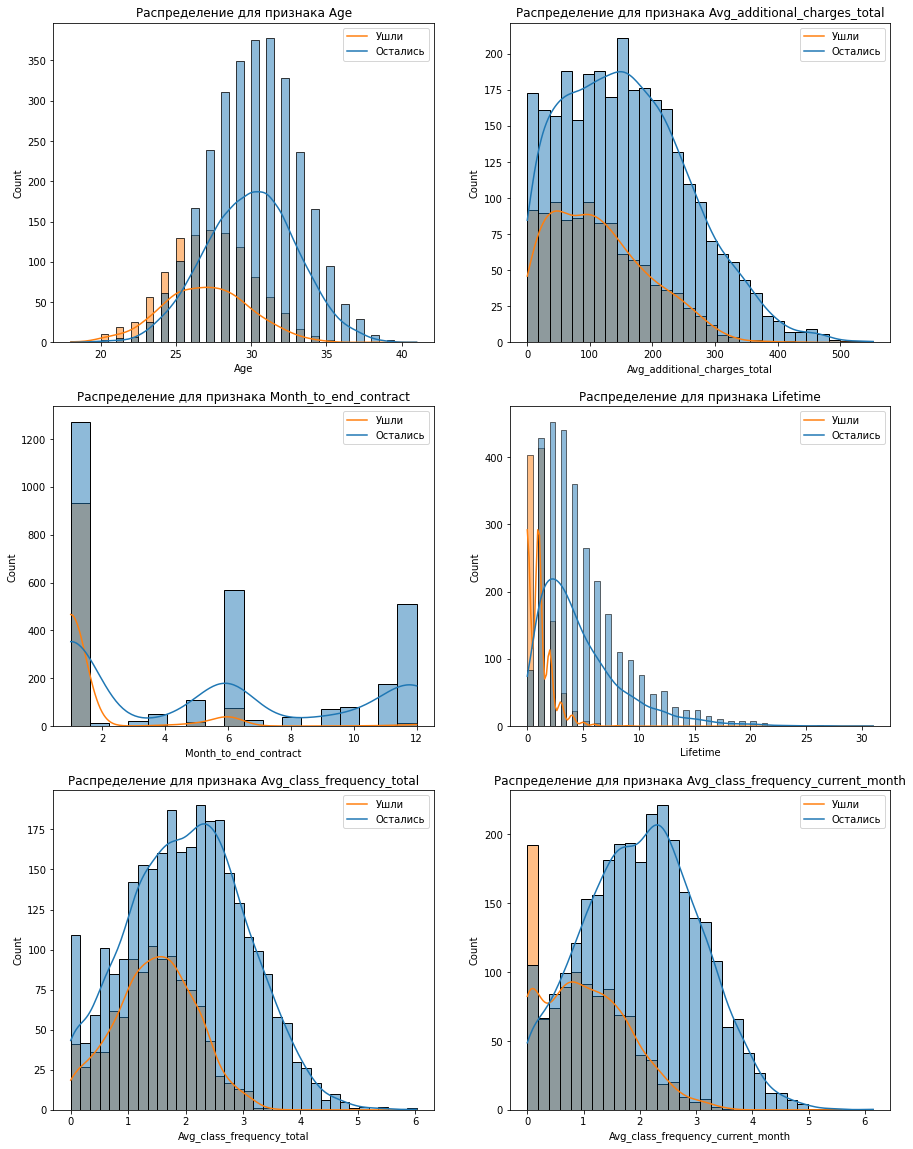

In [8]:
# построим гистограммы

columns_col = ['Age','Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

fig, axes = plt.subplots(3,2, figsize=(15,20))
axes = axes.ravel()

for i,ax in zip(columns_col, axes):
    sns.histplot(data = df, x= df[i], hue = df['Churn'], ax=ax, kde=True)
    ax.set_title('Распределение для признака '+i)
    ax.legend(['Ушли','Остались'])
fig.tight_layout()
plt.show()

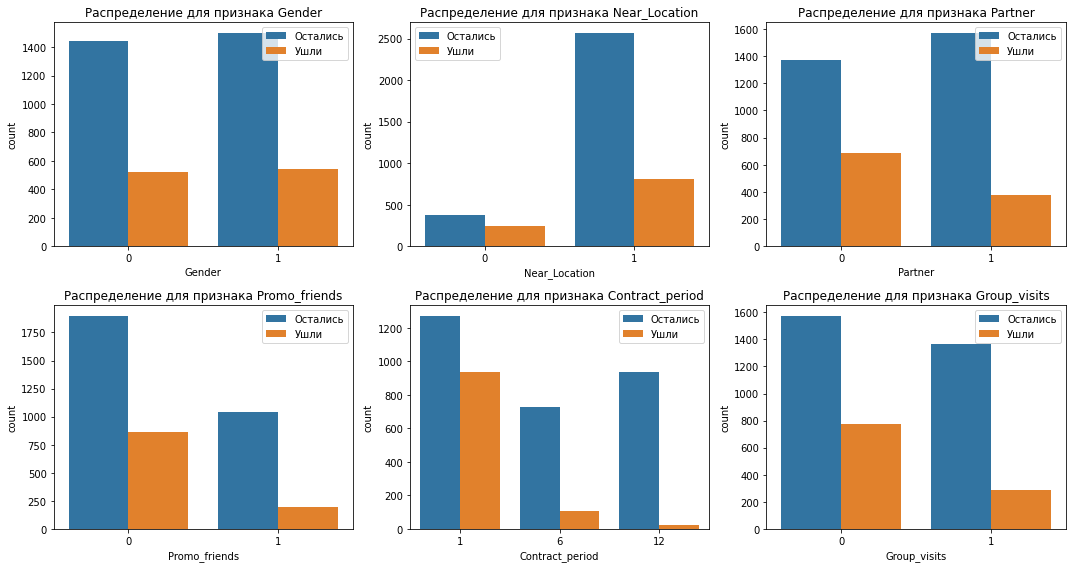

In [9]:
columns = ['Gender', 'Near_Location', 'Partner', 'Promo_friends', 'Contract_period', 'Group_visits']

fig, axes = plt.subplots(2,3, figsize=(15,8))
axes = axes.ravel()

for i,ax in zip(columns, axes):
    sns.countplot(data = df, x= df[i], hue = df['Churn'], ax=ax)
    ax.set_title('Распределение для признака '+i)
    ax.legend(['Остались','Ушли'])
fig.tight_layout()
plt.show()

Как мы видим, близость фитнес-центра к дому или к работе имеет значение, большинство продолжают ходить. <br>
Больше половины клиентов являются сотрудниками компаний-партнеров. Среди ушедших многие как раз не являлись такими сотрудниками. <br>
Акция приведи друга привела и оставила почти треть действующих клиентов. Это очень здорово. <br>
Большинство ушедших клиентов приобретали абонемент на срок не более 2 месяцев. И очень мало кто приобретал абонемент на срок 6 и 12 месяцев. Самый популярным среди всех клиентов является абонемент на срок не более 2 месяц. <br>
Из клиентов, кто ходит на групповые занятия реже бросают заниматься спортом, чем среди тех кто занимается самостоятельно или индивидуально. Все-таки групповая поддержка важна) Хотя занимающихся самостоятельно больше. <br>
Не удивительно, что продолжающие заниматься больше тратят на доп услуги, чем те кто ушли) Возможно этот признак в дальнейшем не стоит рассматривать, так как сумма трат совсем незначительная. <br>
Как было замечено еще на средних, большинство ушедших не отзанимались и два месяца.  <br>
Большинство ушедших посещали центр не более месяца) Т е наибольший отток происходит в первый месяц посещения. <br>
Среднее посещение в неделю за все время среди ушедших и оставшихся похожи. Средние значения описывали выше. <br>
В предыдущем месяце очень много ушло тех кто не занимался ни разу. Возможно была какая-то акция, люди записались, но услугой так и не воспользовались. <br>

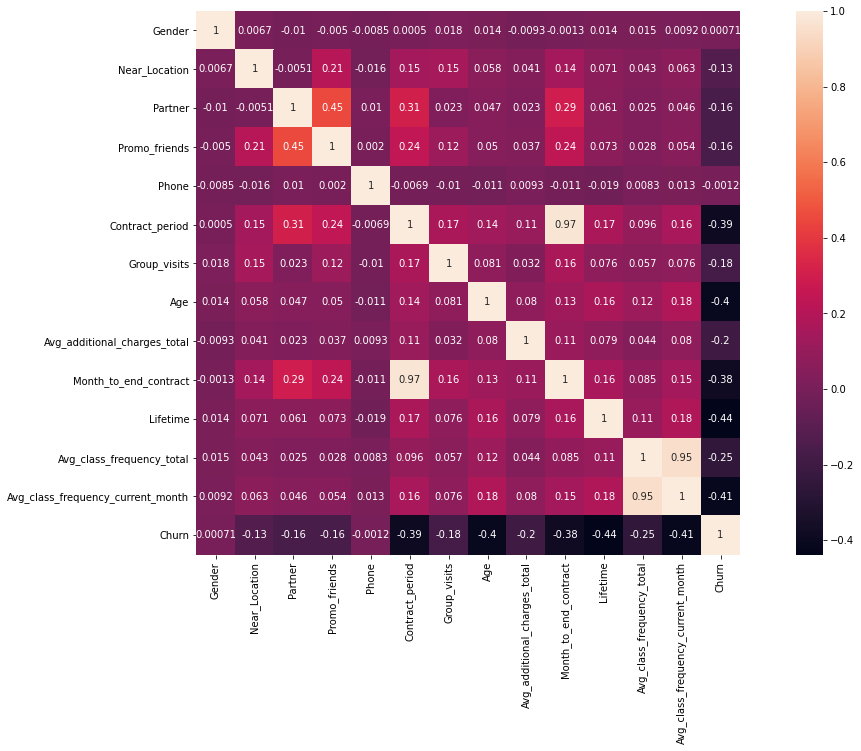

In [10]:
cm = df.corr()
plt.figure(figsize= (20,10))
sns.heatmap(cm, annot=True, square=True);

In [11]:
# удалим зависимые признаки
df_new = df.drop(['Month_to_end_contract', 'Avg_class_frequency_current_month'], axis=1)

Проверим признаки на мультиколлиниарность.<br>
Как я и писала ранее, сильно зависимы друг от друга признаки Month_to_end_contract и Contract_period.<br>
А также Avg_class_frequency_total и Avg_class_frequency_current_month.<br>
В дальнейшем не будем рассматривать признаки Month_to_end_contract и Avg_class_frequency_current_month.<br>

## Вывод


Провела небольшой исследовательский анализ EDA.<br>
Проверила на пропуски и их не оказалось.<br>
Привела все названия столбцов к единому виду.<br>
Изучила средние значения и стандартные отклонения. Посмотрела их же в разрезе по ушедших и оставшимся.<br>
Построила гистограммы количественных признаков и коунтплоты для категориальных признаков.<br>
Построила матрицу корреляции и проверила на мультиколлинеарность.<br>

После исследования можно увидить:

Близость фитнес-центра к дому или к работе имеет значение, большинство продолжают ходить. <br>
Больше половины клиентов являются сотрудниками компаний-партнеров. Среди ушедших многие как раз не являлись такими сотрудниками. <br>
Акция приведи друга привела и оставила почти треть действующих клиентов. Это очень здорово. <br>
Большинство ушедших клиентов приобретали абонемент на срок не более 2 месяцев. И очень мало кто приобретал абонемент на срок 6 и 12 месяцев. Самый популярным среди всех клиентов является абонемент на срок не более 2 месяц. <br>
Из клиентов, кто ходит на групповые занятия реже бросают заниматься спортом, чем среди тех кто занимается самостоятельно или индивидуально. <br>
Продолжающие заниматься больше тратят на доп услуги, чем те кто ушли. <br>
Большинство ушедших не отзанимались и два месяца.  <br>
Наибольший отток происходит в первый месяц посещения. <br>

Обнаружила мультиколлиниарность между парой признаков Month_to_end_contract и Contract_period и Avg_class_frequency_total и Avg_class_frequency_current_month. В дальнейшем не будем рассматривать признаки Month_to_end_contract и Avg_class_frequency_current_month.<br>

# Построение модели прогнозирования оттока клиентов 

In [12]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [13]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = df_new.drop(['Churn'], axis = 1)
y = df_new['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

(3200, 11)
(800, 11)
Количество строк в y_train по классам: [2337  863]
Количество строк в y_test по классам: [602 198]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [2351  849]
Количество строк в y_test по классам: [588 212]


In [15]:
# обучим модель логической регрессией
# задаем алгоритм для нашей модели
model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_lr = model.predict(X_test)
probabilities_lr = model.predict_proba(X_test)[:,1]


# обучим модель случайным лесом
# зададим алгоритм для нашей модели 
tree_model = RandomForestClassifier(n_estimators=100, random_state=0)

# обучим модель
tree_model.fit(X_train, y_train) 

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_rf = tree_model.predict(X_test)



In [16]:
# посчитаем метрики
print_all_metrics(y_test, predictions_lr, 'Метрики классификации для логистической регрессии')
print_all_metrics(y_test, predictions_rf, 'Метрики классификации для случайного дерева')

Метрики классификации для логистической регрессии
	Accuracy: 0.90
	Precision: 0.83
	Recall: 0.80
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.79


Оценим классификаторы:<br>
Accuracy (доля верно угаданных ответов из всех прогнозов) лучше у модели случайного леса, чем у логистической регрессии: 0.89 против 0.88. <br>
Precision (точность) выше у модели случайного леса, чем у логистической регрессии: 0.78 против 0.76.<br>
Recall (полнота) оказалась одинаковой для обоих моделей.<br>
Предварительно можно сказать, что метрики лучше у случайного леса. Для более точного ответа посчитаем еще одну метрику F1-мера.<br>

In [17]:
print('F1 логистической регрессии: {:.2f}'.format(f1_score(y_test, predictions_lr)))
print('F1 случайного леса: {:.2f}'.format(f1_score(y_test, predictions_rf)))

F1 логистической регрессии: 0.81
F1 случайного леса: 0.80


После подсчета данной метрики мы получили подтверждение, что лучшая модель это модель случайного леса.

In [18]:
#переберем гиперпараметр n_estimators

for n in range(80, 151, 10):
    tree_model = RandomForestClassifier(n_estimators=n, random_state=0)
    tree_model.fit(X_train, y_train)
    predictions_rf = tree_model.predict(X_test)
    print(n)
    print_all_metrics(y_test, predictions_rf, 'Метрики классификации для случайного дерева')
    print('F1 случайного леса: {:.2f}'.format(f1_score(y_test, predictions_rf)))

80
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.78
F1 случайного леса: 0.80
90
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.82
	Recall: 0.77
F1 случайного леса: 0.79
100
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.79
F1 случайного леса: 0.80
110
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.76
F1 случайного леса: 0.78
120
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.78
F1 случайного леса: 0.80
130
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.76
F1 случайного леса: 0.79
140
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.76
F1 случайного леса: 0.79
150
Метрики классификации для случайного дерева
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.76
F1 случайного леса: 0.78


# Кластеризация клиентов

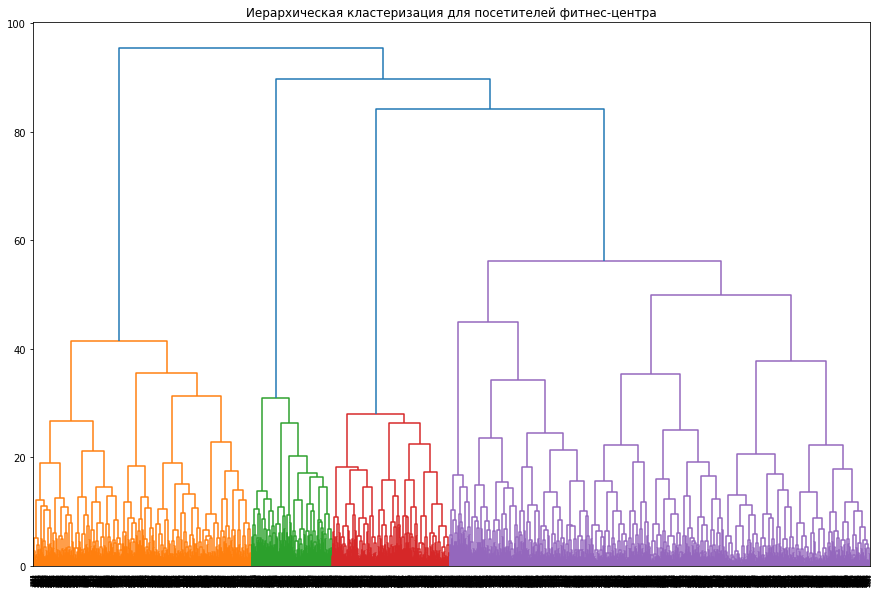

In [19]:
# стандартизируем данные
scaler = StandardScaler()
x_sc = scaler.fit_transform(df_new.drop(columns = ['Churn']))

linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для посетителей фитнес-центра')
plt.show() 


На основании дендограммы можно выделить 5 кластеров. Можно остановиться на расстоянии 50, тогда кластеров будет 5.

Обучим модель на основании алгоритма K-Means. 

In [20]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)
# сохраняем метки кластера в поле нашего датасета
df_new['cluster'] = labels
# посмотрим средние значения признаков для кластеров
#display(df_new.groupby('cluster').mean().T)

cluster_features = df_new.groupby('cluster').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,cluster,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
0,0,0.50,0.00,0.49,0.08,1.00,3.03,0.24,28.72,137.54,3.06,1.77,0.40
1,1,0.49,1.00,0.96,0.89,1.00,7.66,0.46,29.54,155.86,4.38,1.98,0.12
2,2,0.51,1.00,0.24,0.06,1.00,2.82,0.00,28.77,143.38,3.34,1.80,0.38
3,3,0.54,1.00,0.25,0.08,1.00,4.53,1.00,29.54,148.09,3.76,1.94,0.20
4,4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.85,0.27


По признакам gender, Age, Avg_class_frequency_total среднее значение между кластерами различается незначительно.<br>
Признак Near_Location в кластере 0 равен 0. Скорее всего в этом кластере объеденены клиенты, живушие или работающие далеко от фитнес-центра.<br>
Признак Partner и Promo_friends имеет высокие средние в кластере 1.<br>
В кластере 4 объеденены клиенты, которые не оставили свой номер телефона.<br>
Признак Contract_period наибольшее среднее имеет в кластере 1.<br>
В кластере 3 все клиенты ходят на групповые занятия.<br>
Наименьший отток в кластере 1. А вообще не видно какого-то явного признака, объединяющего кластер, по которому происходит отток.<br>

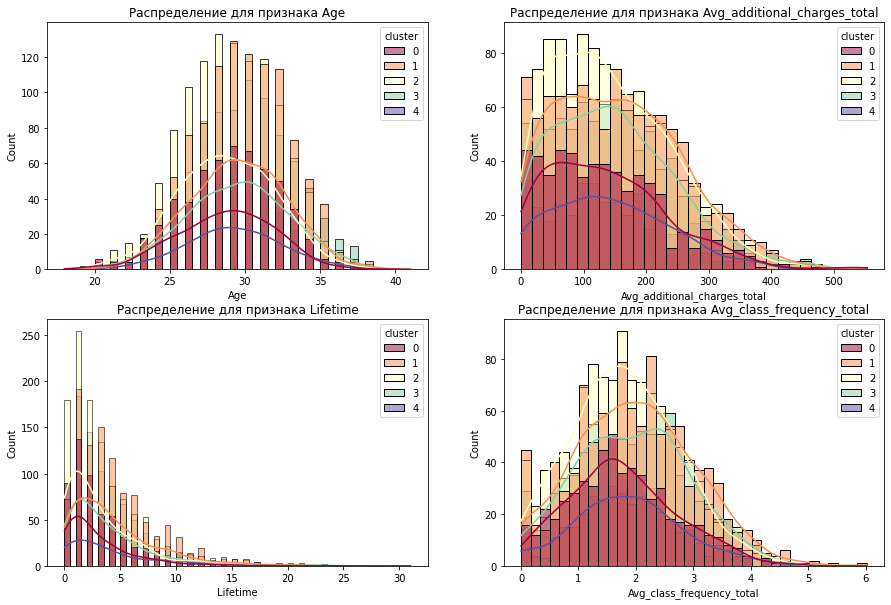

In [21]:
columns_col = ['Age','Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total']

fig, axes = plt.subplots(2,2, figsize=(15,10))
axes = axes.ravel()

for i,ax in zip(columns_col, axes):
 #   sns.histplot(data = df_new, y= df_new[i], x = df_new['cluster'],hue=df_new['Churn'], ax=ax) #, kde=True)
    sns.histplot(data = df_new, x= df_new[i], hue = df_new['cluster'], ax=ax, kde=True, palette = "Spectral")
    ax.set_title('Распределение для признака '+i)

#fig.tight_layout()
plt.show()

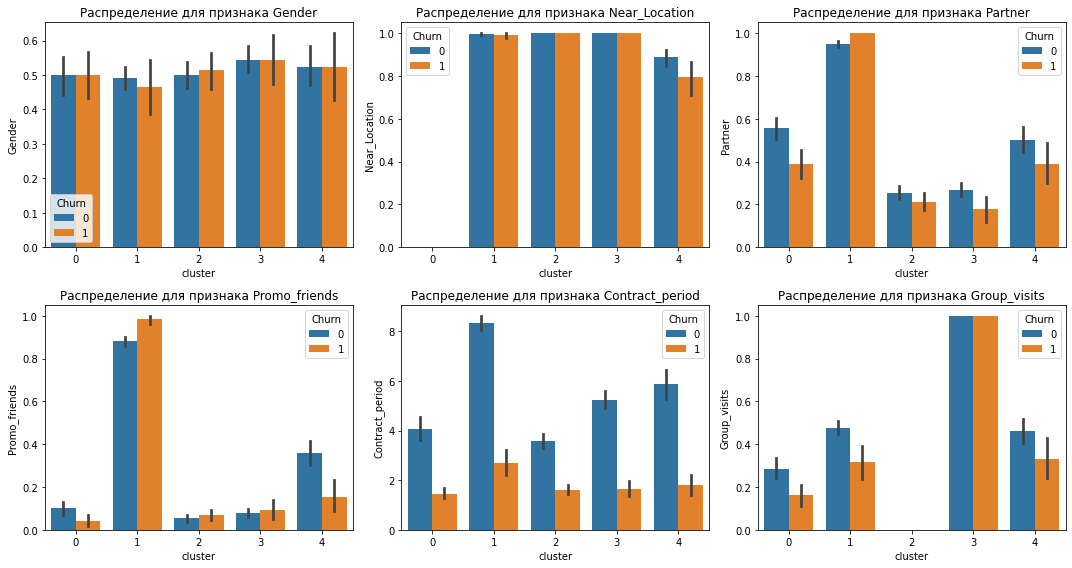

In [22]:
columns = ['Gender','Near_Location', 'Partner', 'Promo_friends', 'Contract_period', 'Group_visits']

fig, axes = plt.subplots(2,3, figsize=(15,8))
axes = axes.ravel()

for i,ax in zip(columns, axes):
    sns.barplot(y = df_new[i], x=df_new['cluster'], hue=df_new['Churn'], ax=ax)
    ax.set_title('Распределение для признака '+i)
 #   ax.legend()
fig.tight_layout()
plt.show()


Сообственно это подтвержают и графики распределения значений.

In [23]:
# посчитаем долю оттока по кластерам
df_cluster = df_new.groupby('cluster').agg({'Churn':'sum'})/df_new.groupby('cluster').agg({'Churn':'count'})*100
df_cluster

,Churn
cluster,
0,39.928699
1,12.095238
2,38.162544
3,20.091848
4,26.683938


Наиболее надежный кластер 1. Кластеры 0 и 2 склонны к оттоку.

# Выводы и рекомендации

Мы провели анализ данных клиентов. Посмотрели, как распределились признаки между ушедшими и оставшимися клиентами.<br>
По половому признаку разницы нет. Те это никак не влияет на отток.<br>
близость фитнес-центра к дому или к работе имеет значение, большинство продолжают ходить. <br>
Из оставшихся клиентов, половина являются сотрудниками компаний-партнеров. Надо это учесть и продолжать сотрудничество с действующими партнерами и заключать договоры с новыми.<br>
Акция приведи друга привела и оставила почти треть действующих клиентов. Это очень здорово. Отличный показатель для акции. Надо повторять.<br>
У тех кто продолжает ходить в центр, абонемент будет действовать еще более 5 месяц. Большинство ушедших клиентов приобретали абонемент на срок не более 2 месяцев. И очень мало кто приобретал абонемент на срок 6 и 12 месяцев. Самый популярным среди всех клиентов является абонемент на срок не более 2 месяц. Я бы рекомендовала работать с новичками, чтобы снизить среди них отток.<br>
Среди ушедших всего 27% было тех, кто ходил на групповые занятия. Получается 73% это те, кто либо занимался самостоятельно, либо индивидуально. <br>
Возможно новичкам надо рекомендовать ходить на групповые занятия, там отток ниже.<br>
Выручка от оплаты доп услуг мала как для тех кто остался, так и для тех кто ушел. Разница всего 40 единиц. <br>
Большинство ушедших посещали центр не более месяца. Т.е. наибольший отток происходит в первый месяц посещения. <br>
В среднем те кто продолжает посещать центр, приходят заниматься 2 раза в неделю. Среди прекративших посещение - большинство ходило 1 раз в неделю.<br>
Среднее посещение в предыдущем месяце подтверждает предыдущий показать: продолжающие заниматься приходили в зал 2 раза неделю, ушедшие приходили  1 раз в неделю.<br>

В предыдущем месяце очень много ушло тех кто не занимался ни разу. Возможно была какая-то акция, люди записались, но услугой так и не воспользовались. <br>

Построили корреляционную таблицу признаков и нашли мультиколлиниарные признаки Month_to_end_contract и Avg_class_frequency_current_month. В дальнейшем анализе эти признаки не рассматривали.<br>

Обучили модель двумя способами: логической регрессией и случайным лесом. <br>

И оценили их классификаторы:<br>
Accuracy (доля верно угаданных ответов из всех прогнозов) лучше у модели случайного леса, чем у логистической регрессии: 0.89 против 0.88. <br>
Precision (точность) выше у модели случайного леса, чем у логистической регрессии: 0.78 против 0.76.<br>
Recall (полнота) оказалась одинаковой для обоих моделей.<br>
Так же посчитали дополнительно метрику F1-мера, которая и подтвердила, что лучшая модель это модель случайного леса.<br>

Постороили дендограмму и остановившись на расстоянии 50,  выделили 5 кластеров.
Обучили модель на основании алгоритма K-Means и получили следущие результаты.

По признакам gender, Age, Avg_class_frequency_total среднее значение между кластерами различается незначительно.<br>
Признак Near_Location в кластере 0 равен 0. Скорее всего в этом кластере объединены клиенты, живущие или работающие далеко от фитнес-центра.<br>
Признак Partner и Promo_friends имеет высокие средние в кластере 1.<br>
В кластере 4 объеденены клиенты, которые не оставили свой номер телефона.<br>
Признак Contract_period наибольшее среднее имеет в кластере 1.<br>
В кластере 3 все клиенты ходят на групповые занятия.<br>
Наименьший отток в кластере 1. А вообще не видно какого-то явного признака, объединяющего кластер, по которому происходит отток.<br>

Сообственно это подтвержают и графики распределения значений.

Наиболее надежным оказался кластер 1. На клиентов с такими признаки и надо ориентироваться. Кластеры 0 и 2 склонны к оттоку.

Рекомендации:
- проводить акции Приведи друга. Много остается новых клиентов(35%)
- увеличивать число компаний-партнеров
- новичкам предлагать грпповые занятия. Возможно предлагать пробовать все групповые занятия хотя бы по одному разу, возможно найдут группу по душе

